<a href="https://colab.research.google.com/github/UrjaPawar/Twitter_US_Sentiment_Analysis/blob/main/Twitter_US_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Challenge:** Perform Sentiment analysis on Twitter US Airline Sentiment. Do a thorough Exploratory Data Analysis of the dataset and report the final performance metrics for your approach. Suggest ways in which you can improve the model.

**Suggestions:**	You can try using ULMFiT. You can also try to apply the EDA augmentation.

**Data:**	https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data#

**Useful papers**
https://arxiv.org/pdf/1801.06146.pdf
https://arxiv.org/pdf/1901.11196.pdf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn import metrics 
from sklearn.metrics import confusion_matrix   
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 3

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
# plotting libraries
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot
from wordcloud import WordCloud

# Exploratory Data Analysis - Twitter US Airlines Dataset

Let's start with loading the data and looking at different features available

In [3]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Tweets.csv")
df.head()

tweet_id  ...               user_timezone
0  570306133677760513  ...  Eastern Time (US & Canada)
1  570301130888122368  ...  Pacific Time (US & Canada)
2  570301083672813571  ...  Central Time (US & Canada)
3  570301031407624196  ...  Pacific Time (US & Canada)
4  570300817074462722  ...  Pacific Time (US & Canada)

[5 rows x 15 columns]

So the feature are

In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

Let's count null values present in different features

In [5]:
df.isna().sum().sort_values(ascending=False)

negativereason_gold             14608
airline_sentiment_gold          14600
tweet_coord                     13621
negativereason                   5462
user_timezone                    4820
tweet_location                   4733
negativereason_confidence        4118
tweet_created                       0
text                                0
retweet_count                       0
name                                0
airline                             0
airline_sentiment_confidence        0
airline_sentiment                   0
tweet_id                            0
dtype: int64

For analysis, we are interested in columns with no missing values as the ones with missing values are missing too many in numbers. 

Out of the columns with no missing values, we are interested in columns: **text** (as it contains the main text), **retweet_count** (to analyse the weight of a tweet with certain sentiment), **airline** (to analyse associations of sentiments with airlines), and **airline sentiment** itself.

In [6]:
data = df[["text","retweet_count","airline","airline_sentiment"]]
data.head()

text  ...  airline_sentiment
0                @VirginAmerica What @dhepburn said.  ...            neutral
1  @VirginAmerica plus you've added commercials t...  ...           positive
2  @VirginAmerica I didn't today... Must mean I n...  ...            neutral
3  @VirginAmerica it's really aggressive to blast...  ...           negative
4  @VirginAmerica and it's a really big bad thing...  ...           negative

[5 rows x 4 columns]

In [7]:
sentiment_colors=['#ff8484','#fed8b1','#9acd32']
fig = px.pie(
    data,
    names='airline_sentiment',
    title='Distribution of sentiments in the data',
    height=500,
    width=800,
    color_discrete_sequence=sentiment_colors
)
fig.show()

Negative reviews are much more than positive/neutral ones. People usually provide more reviews when they are unhappy/dissatisfied with the services offered as compared to when they have a pleasant experience.

How many different airlines are present in this dataset?

In [8]:
set(data['airline'])

{'American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America'}

In [9]:
idx = list(set(data['airline']))
fig = px.pie(
    data,
    names='airline',
    title='Distribution of airlines in the data',
    height=500,
    width=800,
    color_discrete_sequence=['#8A8DBA','#5B75DA','#001E70','#CFA616','#E6F4F1','#36918E']
)
fig.show()

Popularity-wise, United airlines is ahead of all in the tweets and Virgin America is the last one. Let's look at the sentiment distribution in individual airlines to get a better idea of which airlines is positively popular and which ones are negatively popular.

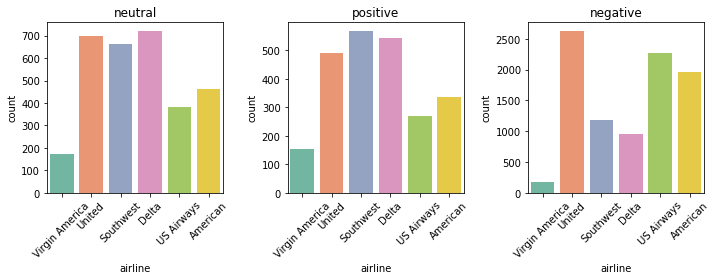

In [10]:
j=1
plt.subplots(figsize=(20,4),tight_layout=True)
for i in data["airline_sentiment"].unique():
        x = data[data["airline_sentiment"]==i]
        plt.subplot(1, 6, j)
        sns.countplot(x["airline"],palette="Set2")
        plt.xticks(rotation=45)
        plt.title(i)
        j +=1
plt.show()

**Airlines with more positive reviews than negative reviews**: Virgin America, Southwest, and Delta airlines

**Airlines with more negative reviews than positive reviews**: United, US Airways, and American airlines

**Airlines with most positive reviews**: Southwest Airlines

**Airlines with most negative reviews**: United Airlines

Let's now look at how many retweets are made on positive vs negative vs neutral tweets for different airlines

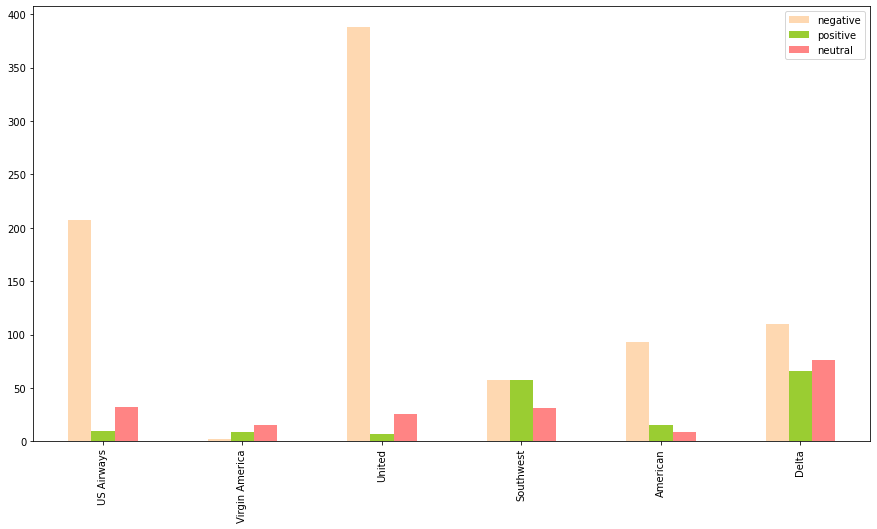

In [11]:
airlines = list(set(data['airline']))
sentiments = list(set(data['airline_sentiment']))
retweets_count=[]
for airline in airlines:
  temp=[]
  d = data[data['airline']==airline]
  for sentiment in sentiments:
    temp.append(sum(d[d['airline_sentiment']==sentiment]['retweet_count']))
  retweets_count.append(temp)

plot_df = pd.DataFrame(retweets_count, index=airlines,columns=sentiments)

plot_df.plot.bar(figsize=(15,8),color=['#fed8b1','#9ACD32','#ff8484'])

It can be seen that highest number of retweets are usually assigned to the negative tweets as compared to positive/neutral tweets. 

Let's further look at the words used in these tweets to analyse their relation to sentiments

Firstly we will analyse the number of words in positive, negative and neutral tweets

In [12]:
neg = data[data['airline_sentiment']=='negative']['text'].str.split().map(lambda x: len(x))
pos = data[data['airline_sentiment']=='positive']['text'].str.split().map(lambda x: len(x))
neu = data[data['airline_sentiment']=='neutral']['text'].str.split().map(lambda x: len(x))

fig = make_subplots(rows=1, cols=3)
fig.add_trace(
    go.Histogram(x=list(neu), name='Neutral Tweets'),
    row=1, 
    col=3,
)
fig.add_trace(
    go.Histogram(x=list(neg), name='Negative Tweets'),
    row=1, 
    col=1
)

fig.add_trace(
    go.Histogram(x=list(pos), name='Positive Tweets'),
    row=1, 
    col=2,
)
fig.update_layout(height=500, width=850, title_text="Word Count")
iplot(fig)

It can be clearly observed that the number of words in negative tweets contain more words as compared to positive/neutral tweets. This is in line with the fact that people tend to provide more specific information regarding what went wrong.

Let's now check the words used in tweets belonging to different sentiments

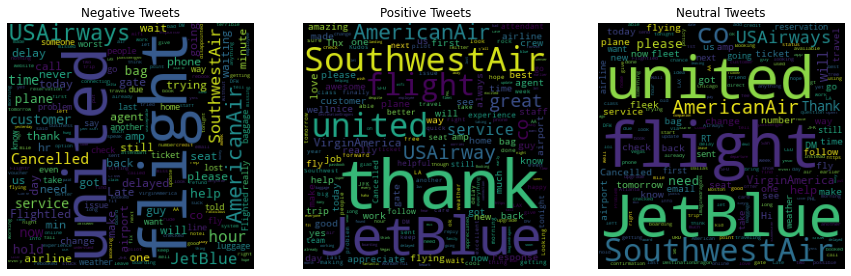

In [13]:
negative = " ".join(data[data['airline_sentiment'] == 'negative']['text'].to_list())
positive = " ".join(data[data['airline_sentiment'] == 'positive']['text'].to_list())
neutral = " ".join(data[data['airline_sentiment'] == 'neutral']['text'].to_list())

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ng_wlc = WordCloud(width=256, height=256, collocations=False).generate(negative)
ps_wlc = WordCloud(width=256, height=256, collocations=False).generate(positive)
ne_wlc = WordCloud(width=256, height=256, collocations=False).generate(neutral)
wcs = [ng_wlc, ps_wlc, ne_wlc]
titles = ["Negative Tweets", "Positive Tweets", "Neutral Tweets"]

for num, el in enumerate(wcs):
    ax[num].imshow(el)
    ax[num].axis('off')
    ax[num].set_title(titles[num])

We see that a lot of frequently occuring words relate to the airline names. So, let's have a closer look at this word cloud for different airlines

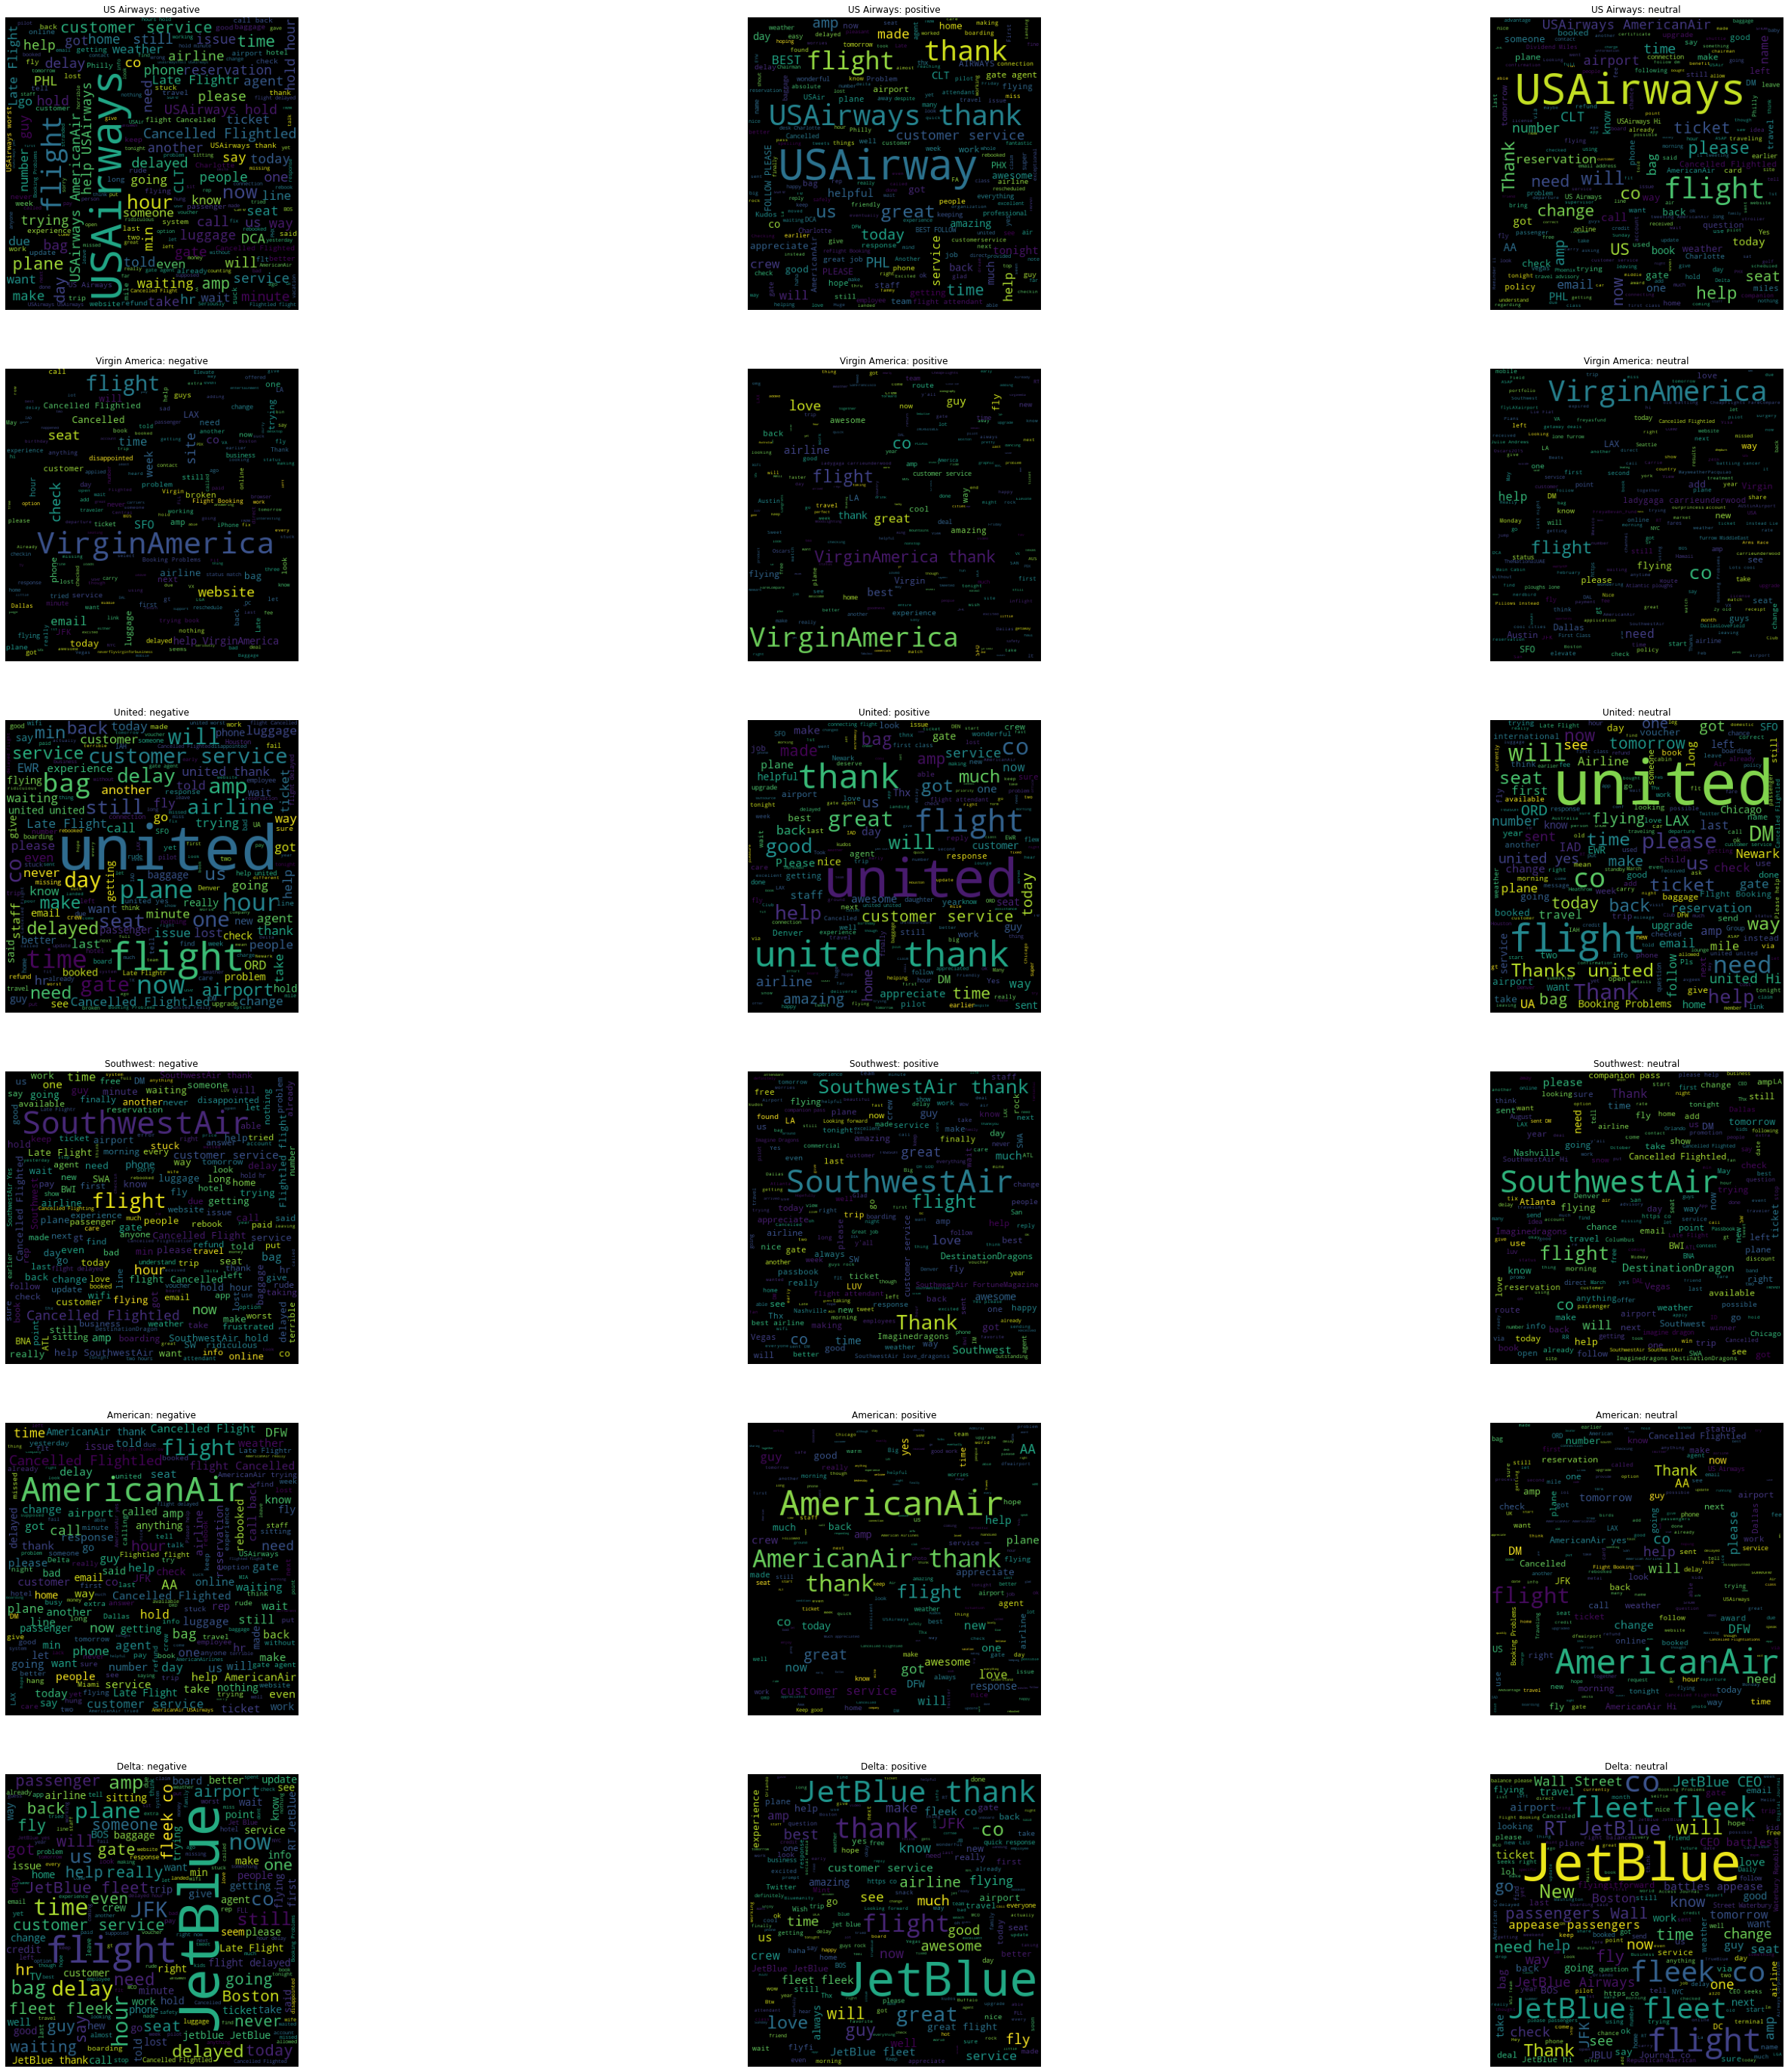

In [14]:
tweets_arr = []
for airline in airlines:
  arr=[]
  d=data[data['airline']==airline]
  for sentiment in sentiments:
    arr.append(" ".join(d[d['airline_sentiment'] == sentiment]['text'].to_list()))
  tweets_arr.append(arr)

fig, ax = plt.subplots(len(airlines), len(sentiments), figsize=(50,50))
wc_arr=[]
for i,airline in enumerate(airlines):
  wc=[]
  for j,sentiment in enumerate(sentiments):
    wc.append(WordCloud(width=400, height=400).generate(tweets_arr[i][j]))
  wc_arr.append(wc)

titles = sentiments

for i,airline in enumerate(airlines):
  for j,sentiment in enumerate(sentiments):
    ax[i][j].imshow(wc_arr[i][j])
    ax[i][j].axis('off')
    ax[i][j].set_title(airline+": "+sentiment)
  


As we can observe, words such as please, help, need etc are common in nutral reviews indicating tweets related to requests from the travelers. 

Words such as appreciate, thank, great, customer services etc are common in positive reviews indicating that travelers appreciated the services offered by airlines.

delayed, callback, cancelled, customer service are some of the words that are found frequently used in negative reviews.

Furthermore, words such as seat and gate are more often used in negative reviews of united airlines as compared to words related to delay and late flight in delta airlines

# EDA (Easy  Data Augmentation)

As the number of tweets corresponding to negative sentiments are much more than the ones belonging to positive/neutral class, we need to apply some augmentation techniques to balacne the data.

Augmentation in categorical and image datasets is easy as it does not require the context of the domain. For NLP tasks, EDA: Easy  Data Augmentation has been proposed in [1] to enable augmentation of text records. It is done via 4 approaches, namely: 

* Synonym Replacement (SR): Randomly replace n words in the sentences with their 
synonyms.

* Random Insertion (RI): Insert random synonyms of words in a sentence, this is done n times.

* Random Swap (RS): Two words in the sentences are randomly swapped, this is repeated n-times.

* Random Deletion (RD): Random removal for each word in the sentence with a probability p. 

In this dataset, it makes sense to use approach of Synonym Replacement (SR) as in any of the tweet the meaning won't change after having a synonym instead of a given word. For this we will use nlp data-augmentation library from here: https://github.com/makcedward/nlpaug

[1] Wei, J. and Zou, K., 2019. Eda: Easy data augmentation techniques for boosting performance on text classification tasks. arXiv preprint arXiv:1901.11196.


In [15]:
# For sentiment analysis, we are interested in text as input and airline_Sentiment as labels
from sklearn import model_selection
TEST_SIZE = 0.2
trainXdf, testXdf, trainYdf, testYdf = model_selection.train_test_split( data['text'], data['airline_sentiment'], test_size = TEST_SIZE, random_state = RANDOM_STATE, shuffle=True)
print("No. of records in Train data: ",len(trainXdf), "\n No. of records in Test data: ",len(testXdf))

No. of records in Train data:  11712 
 No. of records in Test data:  2928


Let's apply SR EDA to the train data.

Note that we won't apply augmentation to test as we are interested in testing on original data

In [16]:
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv; pip install nltk

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-iyem_cpf
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-iyem_cpf
  Created wheel for nlpaug: filename=nlpaug-1.1.3-cp37-none-any.whl size=837272 sha256=19814c3e92481dbe3d8aaee258a77baefeab78f20687330d8765f7121bcc396a
  Stored in directory: /tmp/pip-ephem-wheel-cache-waecctij/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


In [17]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [18]:
import random
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
# No. of records for positive, neutral, and negative tweets
pos = trainXdf.loc[trainYdf == 'positive']
neu = trainXdf.loc[trainYdf == 'neutral']
neg = trainXdf.loc[trainYdf == 'negative']

print("There are ", len(pos)," positive tweets,", len(neu)," neutral tweets and ",len(neg)," negative tweets")

pos_req = len(neg)-len(pos)
neu_req = len(neg)-len(neu)


for n in range(pos_req):
  rn = random.randint(0, len(pos)-1)
  row = pos.iloc[rn]
  # SR EDA
  syn = naw.SynonymAug(aug_src='wordnet')
  new_txt = syn.augment(row)
  trainXdf=trainXdf.append(pd.Series({'text':new_txt}), ignore_index=True)
  trainYdf=trainYdf.append(pd.Series({'airline_sentiment':'positive'}), ignore_index=True)

for n in range(neu_req):
  rn = random.randint(0, len(neu)-1)
  row = neu.iloc[rn]
  # SR EDA
  syn = naw.SynonymAug(aug_src='wordnet')
  new_txt = syn.augment(row)
  trainXdf=trainXdf.append(pd.Series({'text':new_txt}), ignore_index=True)
  trainYdf=trainYdf.append(pd.Series({'airline_sentiment':'neutral'}), ignore_index=True)

print("In a balanced training dataset, there are now in total",len(trainXdf),"records")
trainXdf=pd.DataFrame(trainXdf,columns=['text'])
testXdf=pd.DataFrame(testXdf,columns=['text'])

There are  1878  positive tweets, 2449  neutral tweets and  7385  negative tweets
In a balanced training dataset, there are now in total 22155 records


In [19]:
print("Number of records in training set are now: ",len(trainXdf))

Number of records in training set are now:  22155


In [20]:
traindf=pd.DataFrame({'airline_sentiment':trainYdf,'text':trainXdf['text']})
testdf=pd.DataFrame({'airline_sentiment':testYdf,'text':testXdf['text']})


### Now after this, let's do the tokenisation

This will build up a dictionary of words and have a representation of words in numeric format

In [21]:
from fastai.text import *
data_ = TextClasDataBunch.from_df(path="/content/gdrive/My Drive/Colab Notebooks/",train_df=traindf, valid_df=testdf)
data_.show_batch()

Here is the vocabulary built

In [22]:
data_.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 '@',
 'to',
 '!',
 'the',
 '/',
 'i',
 'you',
 'a',
 '?',
 ',']

As we can see at the starting of this list, the unknown tokens identified were replaced by special tokens (prefix:xx)

And this is how the numeric encoding looks like for one of the records:

In [23]:
print(data_.train_ds[0][0])
print(data_.train_ds[0][0].data)

xxbos @americanair what is going on with the flight xxunk ? xxmaj it has been delay a lot .
[  2  39  74  29 182  22  41  13  24   0  18   5  32 142  92 214  17 640   9]


# Tranfer Learning
Let's first load all the deep learning 

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.models import Sequential

#  Model - Keras - RNN
from keras.layers import Embedding, LSTM, Bidirectional
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
from keras.layers import LeakyReLU, PReLU, Lambda, Multiply

from keras.preprocessing import sequence
from keras import regularizers
from keras.optimizers import RMSprop, Adam
from fastai.imports import *


### Fine-tuning pre-trained language model

Fast AI offers pretrained language models to enable an aligned word embedding schemes. This will help in capturing some level of meaning from the tweets.

Let's now create the language model data using FastAI's library 

In [25]:
from fastai.text import *
lm_data = (TextList.from_df(trainXdf,cols='text')
            .random_split_by_pct(0.1, seed = 42)
            .label_for_lm()      
            .databunch())
lm_data.save('/content/gdrive/My Drive/Colab Notebooks/lm_data.pkl')

In [26]:
lm_data.show_batch()


Setting learning rate while defining the language model

In [27]:
learn = language_model_learner(lm_data, AWD_LSTM, drop_mult=0.4)


In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


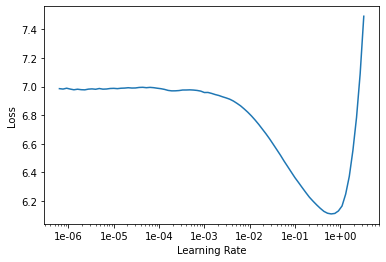

In [29]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(1, 1e-2)

In [32]:
learn.save('/content/gdrive/My Drive/Colab Notebooks/first_lr')
# learn.load('first_lr')

In [33]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(10, 1e-3)

The accuracy is poor which might have happened due to the following reasons:
1. Lack of proper grammar in the tweets
2. Lack of strcture in the tweets as the tweet length is limited
3. More number of misspelled words as twitter is a social website

In [35]:
learn.save('/content/gdrive/My Drive/Colab Notebooks/ft')

In [36]:
learn.save_encoder('/content/gdrive/My Drive/Colab Notebooks/ft_enc')

### Fine-tuning the pre-trained classifier using the tuned language model

Building the classification data

In [37]:
from fastai.text import *
cls_data = (TextList.from_df(traindf,cols='text')
            .random_split_by_pct(0.1, seed = 42)
            .label_from_df(cols='airline_sentiment')      
            .databunch())
cls_data.save('/content/gdrive/My Drive/Colab Notebooks/cls_data.pkl')

In [ ]:
cls_data.show_batch()

Now we will use the encoder from the tuned language model to build our classifier. This enhances the performance of the classifier as the language model learns the structure of the tweets that leads to an improved prediction of sentiments

In [38]:
clf_learn = text_classifier_learner(cls_data, AWD_LSTM, drop_mult=0.3, metrics=[accuracy,Precision(average='weighted'),Recall(average='weighted')])
clf_learn.load_encoder('/content/gdrive/My Drive/Colab Notebooks/ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19940 items)
x: TextList
xxbos @americanair what is going on with the flight xxunk ? xxmaj it has been delay a lot .,xxbos @united yes , would love an upgrade or voucher , please give me a call 9148445695,xxbos @united how is xxmaj mexico not international from the us ?,xxbos .@americanair can you connect me to a person without having to wait 2 + hours on hold ? i still have n't been able to resolve the problem .,xxbos @jetblue what crew ? xxmaj no one here is helping .
y: CategoryList
negative,neutral,neutral,negative,negative
Path: .;

Valid: LabelList (2215 items)
x: TextList
xxbos @usairways 4 hrs and counting today alone ... like i do n't have other things to xxunk today than to just keep holding ! ! !,xxbos .@southwestair i will if you can see about moving up my xxmaj brother in laws xxunk to the 6th . xxmaj thanks .,xxbos @ virginamerica xxmaj take in a great week 🌞 ✈,xxbos @united , more lies ... http : / / t.co / xxunk,xxbo

As suggested in [2], we will run one epoch on subsequent unfreezing of layers of the pre-trained model

[2] Howard, J. and Ruder, S., 2018. Universal language model fine-tuning for text classification. arXiv preprint arXiv:1801.06146.




LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


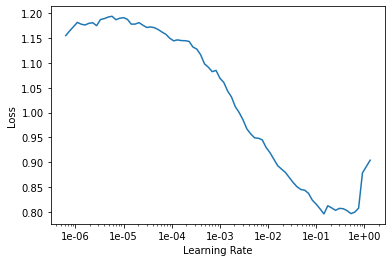

In [39]:
clf_learn.lr_find()
clf_learn.recorder.plot()

In [40]:
clf_learn.fit_one_cycle(1, 1e-2)

In [41]:
clf_learn.freeze_to(-2)
clf_learn.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-3))

In [42]:
clf_learn.unfreeze()
clf_learn.fit_one_cycle(8, slice(1e-5/(2.6**4),1e-5))
clf_learn.save('final')

In [43]:

preds = testdf['text'].apply(lambda row: str(clf_learn.predict(row)[0]))

In [44]:
print("Test Accuracy: ", metrics.accuracy_score(testdf['airline_sentiment'], preds))

Test Accuracy:  0.7728825136612022


The test accuracy looks decent, let's look at the confusion matrix to see the prediction performance for each sentiment

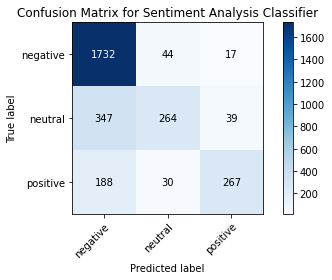

In [45]:
# Ref: https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels 
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title="Confusion Matrix for Sentiment Analysis Classifier",
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(testdf['airline_sentiment'], preds, classes=['negative', 'neutral', 'positive'])
plt.show()

The model performs best for negative tweets, fair for positive tweets and not good for the neutral tweets. This could happen due to the following reasons:
1. Lack of structure and proper grammar in tweets
2. Sarcastic/humour content in tweets
3. Lack of sufficient data

In the future it will be interesting to apply more advanced feature engineering techniques and to collect more relevant data to construct a better language model and sentiment classifier